1/1 [==============================] - 0s 461ms/step


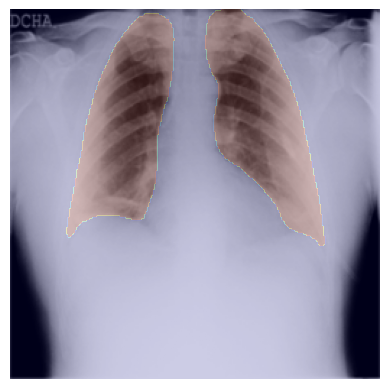

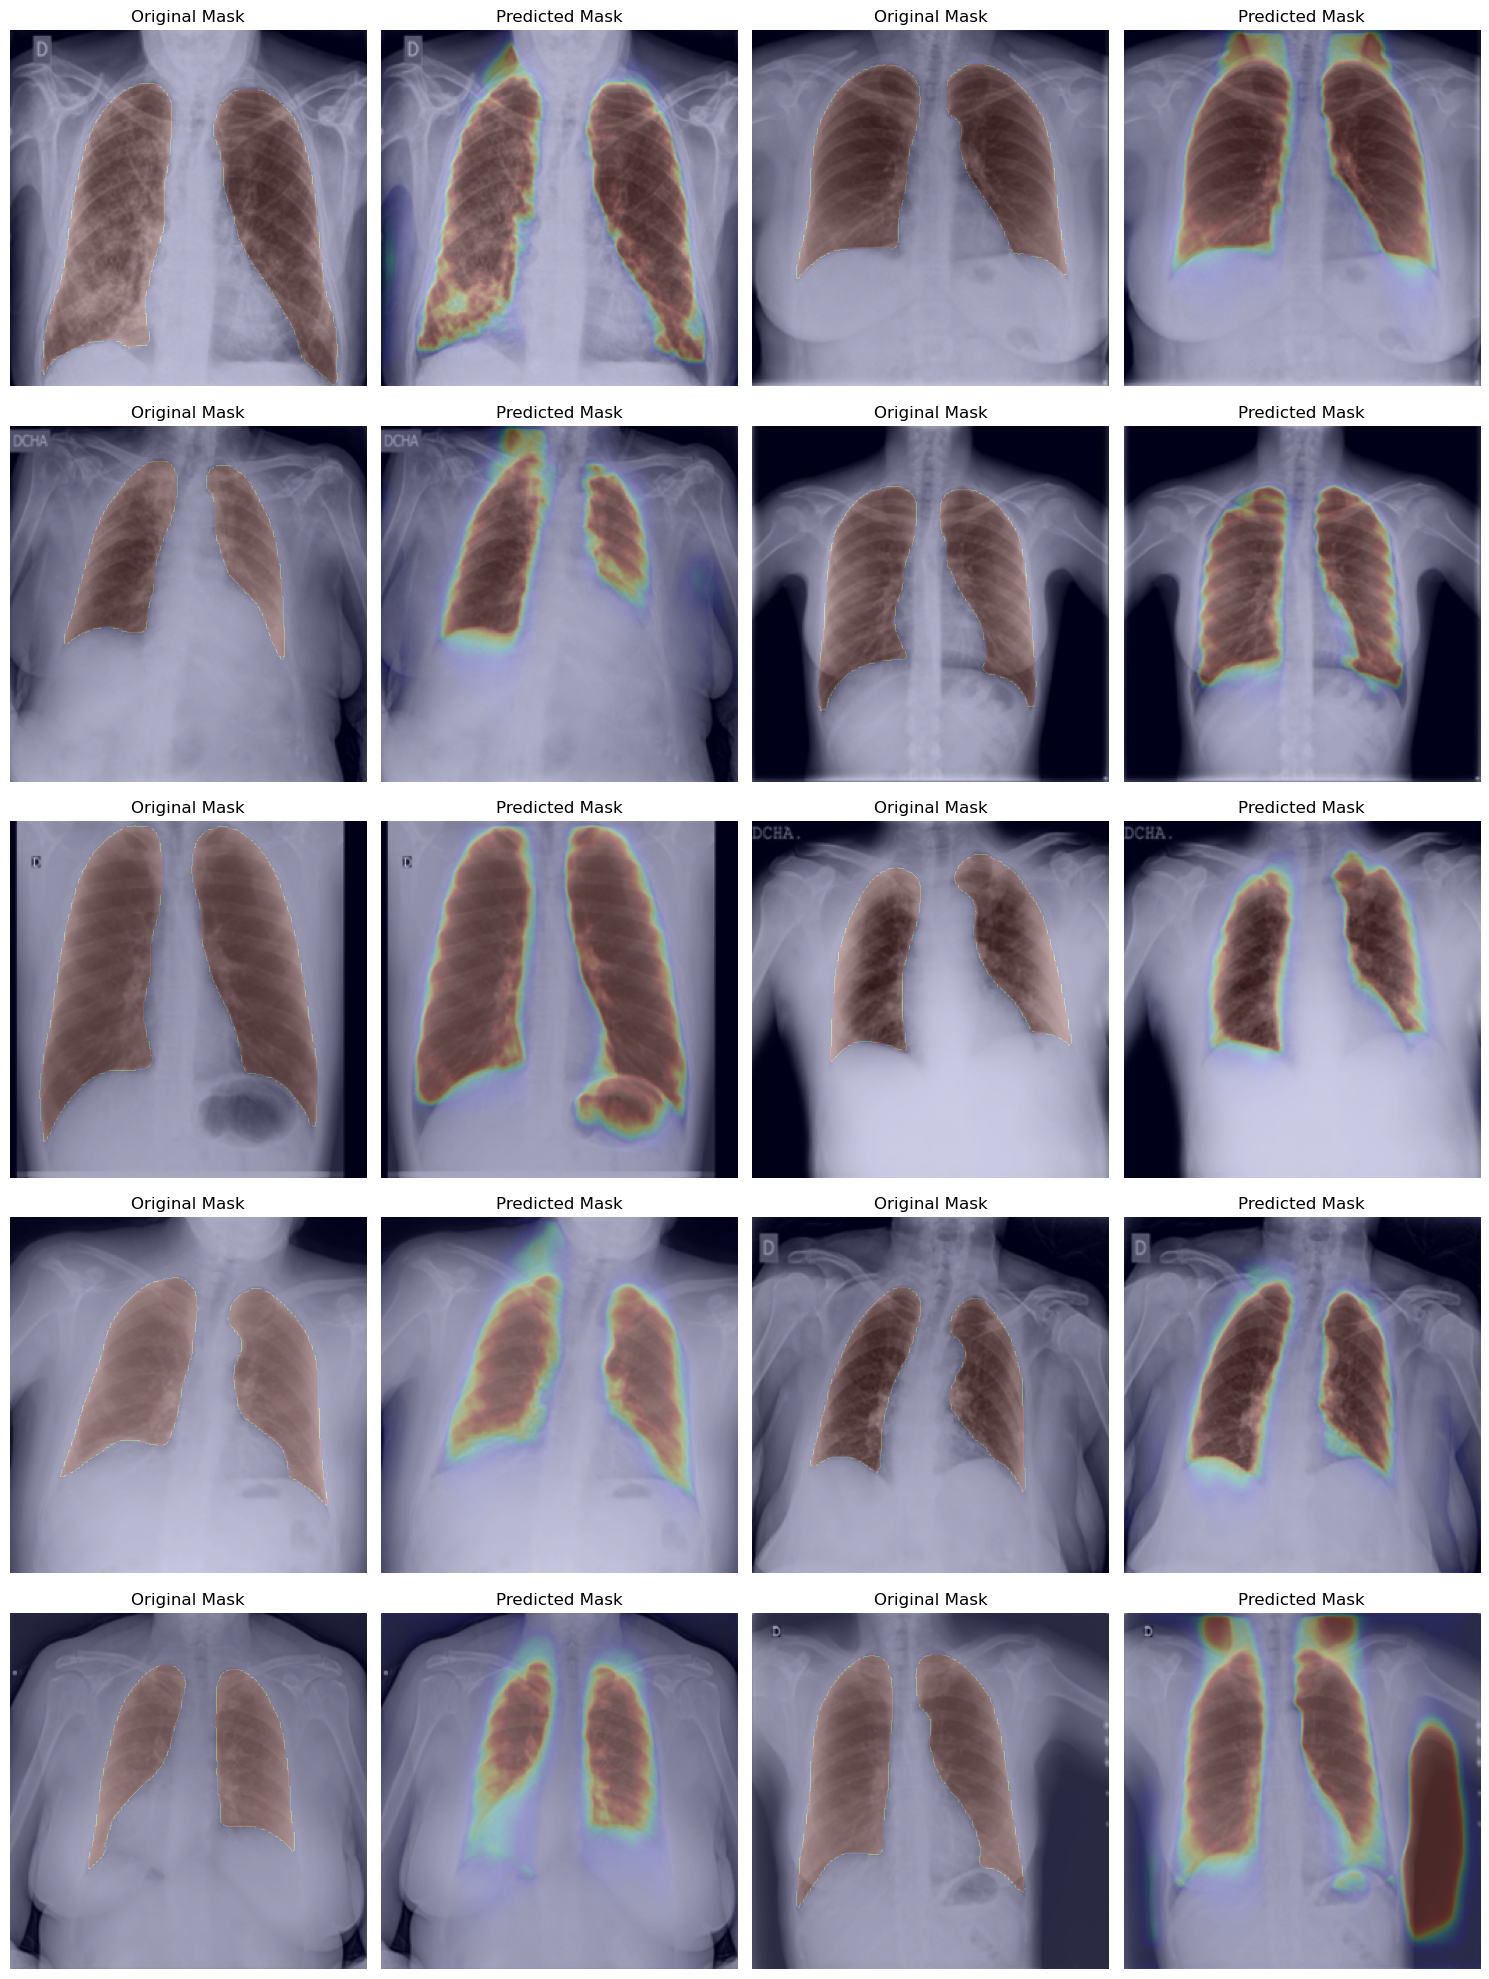

In [1]:
import os 
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf
import matplotlib.pyplot as plt

# Model 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Conv2DTranspose, Input
from tensorflow.keras.layers import Multiply, Add
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

def load_image(image_path, SIZE):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype(np.float32) / 255.0
    return image

def load_images(paths, SIZE, trim=None, channels=3):
    if trim is not None:
        paths = paths[:trim]
    images = []
    for path in paths:
        img = load_image(path, SIZE)
        if channels == 1:
            img = img[:, :, :1]
        images.append(img)
    return np.array(images)

def show_image(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(np.squeeze(mask), cmap=cmap, alpha=alpha)

# Model Definition
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D()(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)

    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

# Data paths
root_path = "F:/RP_YS/dataset/archive (2)/COVID-19_Radiography_Dataset/COVID/"
image_path = os.path.join(root_path, 'images/')
mask_path = os.path.join(root_path, 'masks/')

output_path = os.path.join(root_path, 'output_images/images/')
os.makedirs(output_path, exist_ok=True)

# Load image paths
image_paths = sorted(glob(os.path.join(image_path, '*.png')))
mask_paths = [path.replace('images', 'masks') for path in image_paths]

# Load images and masks
images = load_images(image_paths, SIZE=256, trim=2000)
masks = load_images(mask_paths, SIZE=256, trim=2000, channels=1)

# Display sample
if len(images) > 0 and len(masks) > 0:
    show_mask(images[0], masks[0], alpha=0.2)
else:
    print("Images or masks array is empty.")

# # Display sample
# show_mask(images[0], masks[0], alpha=0.2)

# Model Compilation and Training
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(2)])

# Training
BATCH_SIZE = 8
SPE = len(images) // BATCH_SIZE

unet.fit(
    images, masks,
    validation_split=0.1,
    epochs=1,
    steps_per_epoch=SPE
)

# Save Output Images
for i in range(len(images)):
    image = images[i]
    pred_mask = unet.predict(image[np.newaxis, ...])[0]

    # Save the original image
    cv2.imwrite(os.path.join(output_path, f'original_{i}.png'), cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    # Save the predicted mask
    cv2.imwrite(os.path.join(output_path, f'predicted_mask_{i}.png'), (pred_mask * 255).astype(np.uint8))

# Display predictions
plt.figure(figsize=(15, 20))
n = 0
for i in range(1, 21):
    plt.subplot(5, 4, i)

    if n == 0:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n += 1
    elif n == 1:
        pred_mask = unet.predict(image[np.newaxis, ...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n += 1
    elif n == 2:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n += 1
    elif n == 3:
        pred_mask = unet.predict(image[np.newaxis, ...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n = 0
plt.tight_layout()
plt.show()
